# End-to-end Multi-class Dog Breed Identification

End-to-end Multil-class Dog Breed Classification

# Problem Definition

> When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

# Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

Some information about the data:
* We're dealing with images (unstructured data) so it's best to use deep learning/transfer learning.
* There are 120 breeds of dogs/classes.
* There are around 10,000+ images in the both the training & test sets.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub 

In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

In [4]:
tf.__version__, hub.__version__

('2.9.1', '0.12.0')

### Data Exploration

In [5]:
labels_csv = pd.read_csv('data/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


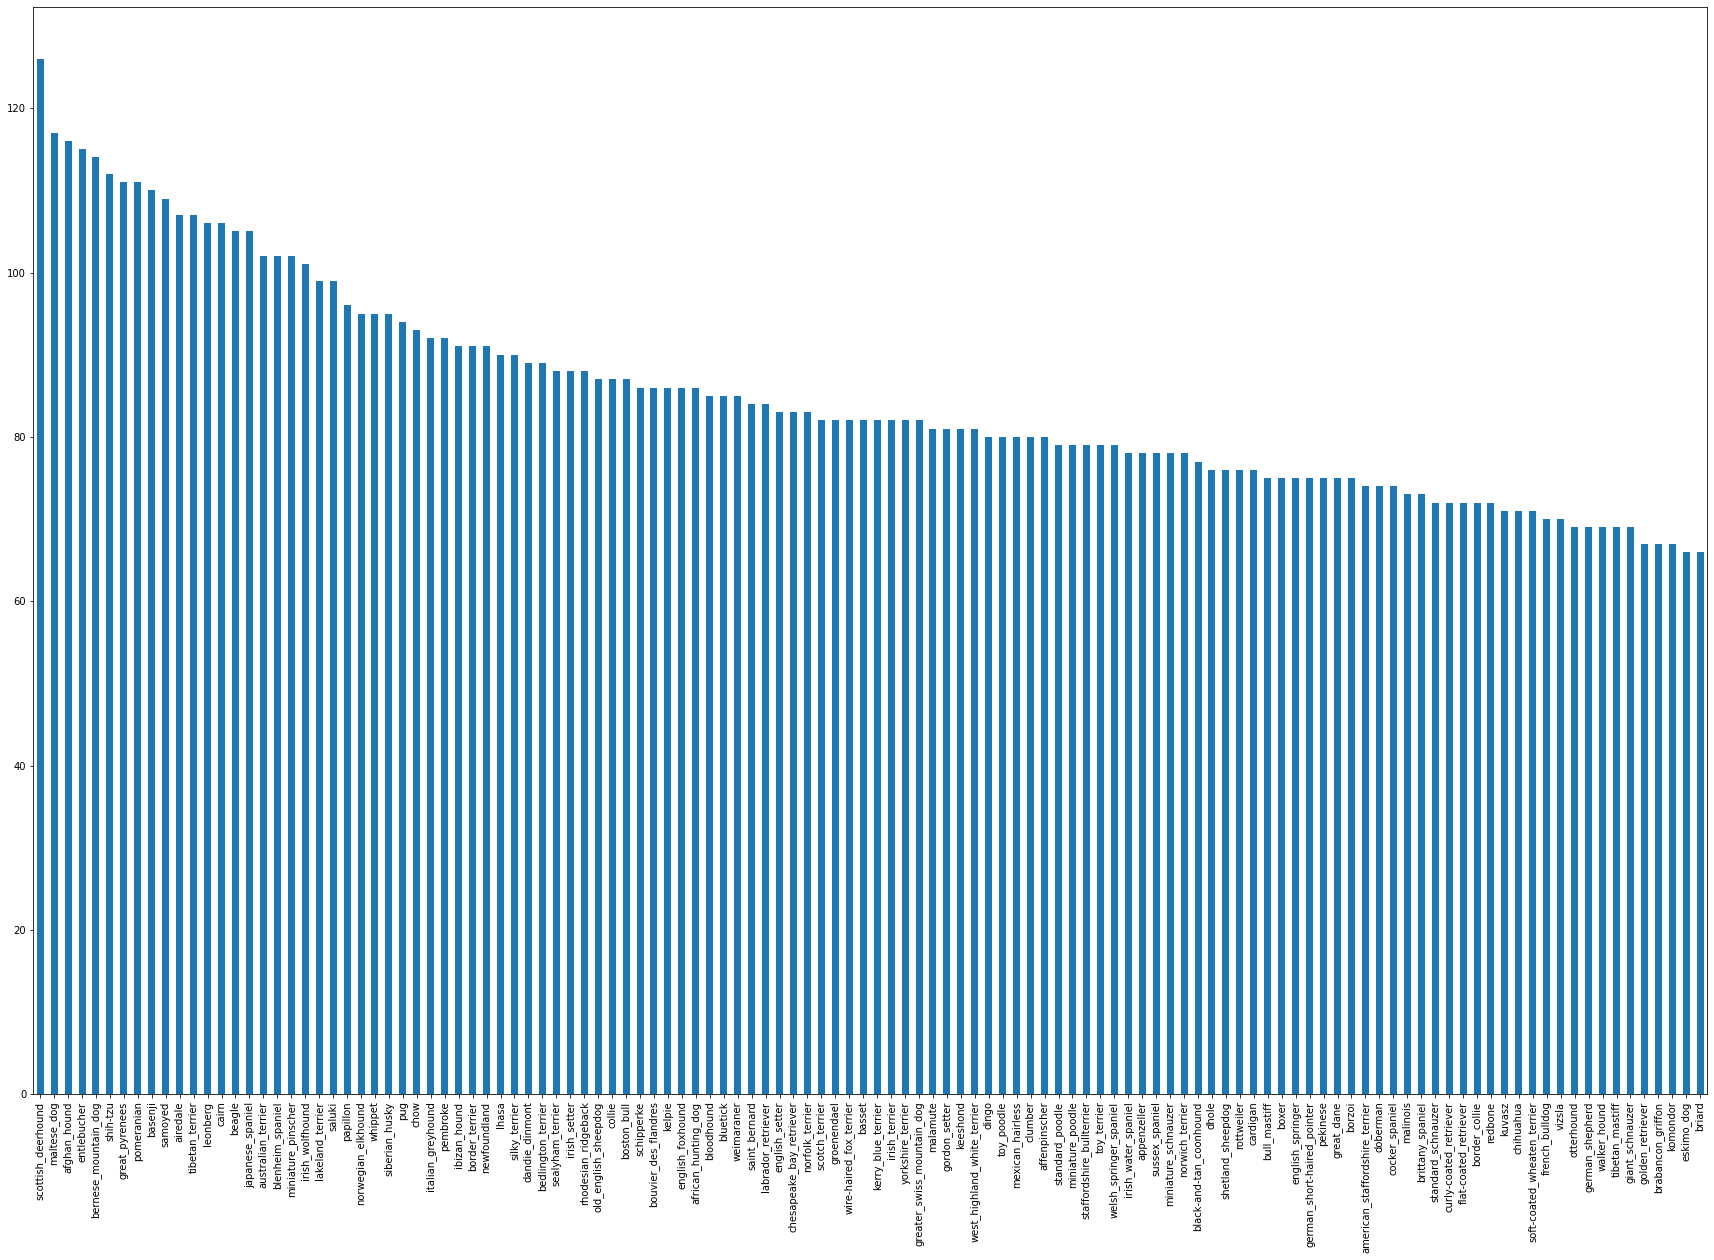

In [7]:
# How many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(30, 20));

In [8]:
labels_csv['breed'].value_counts().median()

82.0

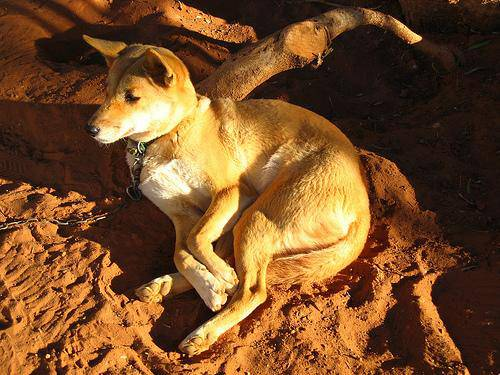

In [9]:
Image.open('data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

In [18]:
# Check all unique breeds
labels = labels_csv['breed'].to_numpy()
filenames = [f'data/train/{fname}.jpg' for fname in labels_csv['id']]
unique_breeds = np.unique(labels)
filenames[:10], unique_breeds

(['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
  'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
  'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
  'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
  'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
  'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg'],
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'b

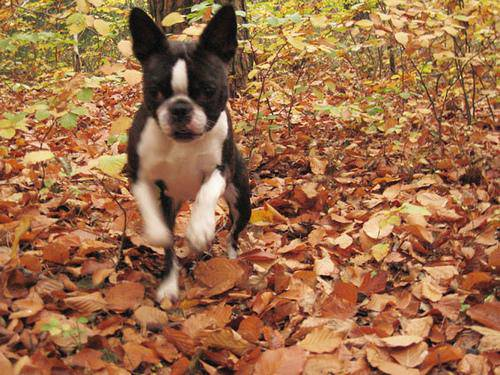

In [13]:
Image.open(filenames[0])

### Create Validation Set

Kaggle doesn't provide a validation set

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
# Use subset of samples for faster experimentation
NUM_IMAGES = 1000
X = filenames
y = boolean_labels

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocess Images (Convert unstructured data to Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1)
5. Resize the image to be a shape of (224, 224) and return it

In [28]:
test_image = plt.imread(filenames[0])

# 3-dimensional (RGB each from 0 to 255)
test_image.shape, test_image.max(), test_image.min()

((375, 500, 3), 255, 0)

In [29]:
# Image numPy array as a tensor
tf.constant(test_image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  7

In [30]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  '''
  Takes an image file path and turns the image into a Tensor.
  '''

  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor of RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image